# Integer Programming

In the last session, you learned about the JuMP ecosystem and solved simple continuous optimization problems.
You've probably worked with JuMP to solve even more complicated LPs in 15.081.
In this session, we'll look into other types of problems, namely, **integer and nonlinear optimization problems**.

In the first half of the session, we'll focus on (Mixed) Integer Programming, which studies optimization problems in which some or all of the variables are restricted to be integers. Integer programs model situations where we need to make discrete decisions, which are frequently encountered in Operations Research.

**REMARK:** The simplest case of IP, namely, Binary Integer Linear Programming is NP-complete. So shouldn't we just go home?


## I. IP Basics

### I.1. Ryan's Unbounded Knapsack

Every morning, Ryan goes to the coffee shop and gets as much coffee as possible to be productive during the day.
There are $N$ types of coffee he can choose from, each with different caffeine content $v_i$ and price $w_i$ (you may assume that the coffee shop has an infinite supply of each coffee type).
Apparently Ryan doesn't want to go bankrupt, so he won't spend more that $C$ dollars. 
How does he choose what coffees to buy to maximize his caffeine intake and hence his productivity?

We can model Ryan's situation as a (pure) integer optimization problem:

\begin{align*}
\max& \sum_{i=1}^N v_i x_i \\
\text{s.t.}& \sum_{i=1}^N w_i x_i \leq C \\
& x_i \in \mathbb{Z}_{\geq 0} \quad \forall i = 1,\ldots,N
\end{align*}

Variable $x_i$ expresses the number of coffees of type $i$ Ryan will buy. (Ryan's favorite coffee shop only sells one-sized coffee, so all variables are constrained to be integer.)


#### A Toy Example

In particular, let's look into the following toy problem:

\begin{align*}
    \max\:& x + y + 1.5 z \\
    \text{s.t.}\:& x + 2y + 3z \leq 5.5 \\
    & x, y, z \in \mathbb{Z}_{\geq 0}
\end{align*}

How would you solve this? 

In [15]:
using JuMP, Gurobi, LinearAlgebra

# Small toy problem from above
values = [1,1,1.5]
weights = [1,2,3]
C = 5.5

# Another small problem (from JuMP documentation)
# values = [5, 3, 2, 7, 4]
# weights = [2, 8, 4, 2, 5]
# C = 10

function solve_knapsack(values, weights, C)
    N = length(values)
    knapsackModel=Model(Gurobi.Optimizer)
    @variable(knapsackModel, x[1:N]>=0, Int)
    @constraint(knapsackModel, capacity, dot(x, weights) <= C)
    @objective(knapsackModel, Max, dot(x, values))
    print(knapsackModel)
    optimize!(knapsackModel)
    return value.(x), objective_value(knapsackModel), knapsackModel
end

x_opt, val_opt, model = solve_knapsack(values, weights, C)
println("Optimal solution = $x_opt \nOptimal value = $val_opt")

Academic license - for non-commercial use only
Max x[1] + x[2] + 1.5 x[3]
Subject to
 capacity : x[1] + 2 x[2] + 3 x[3] ≤ 5.5
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 x[3] ≥ 0.0
 x[1] integer
 x[2] integer
 x[3] integer
Academic license - for non-commercial use only
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Variable types: 0 continuous, 3 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 6e+00]
Found heuristic solution: objective 5.0000000
Presolve removed 1 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 5 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+00, best bound 5.000000000000e+00, gap 0.0000%
Optimal solution = [5.0, -0.0, -0.0] 
Optimal value = 5.0


#### Modifying the Problem
During happy hour, the coffee shop sells coffee of type z with a 50% discount. Thankfully, Ryan has already computed the optimal solution before the discount, so he hopes that he can slightly modify his existing model and resolve it, taking advantage of any knowledge he already has.
    
In the latest versions of JuMP, we can modify and delete constraints as follows:

In [16]:
println("\nModel before modification:")
print(model)
println(" --> Objective value = $(objective_value(model))")

# Now let's modify the model
z = all_variables(model)[3]
con = constraint_by_name(model,"capacity")
set_normalized_coefficient(con, z, 1.5)

println("\nModel after modification:")
print(model)
println()
optimize!(model)
println(" --> Objective value = $(objective_value(model))")


Model before modification:
Max x[1] + x[2] + 1.5 x[3]
Subject to
 capacity : x[1] + 2 x[2] + 3 x[3] ≤ 5.5
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 x[3] ≥ 0.0
 x[1] integer
 x[2] integer
 x[3] integer
 --> Objective value = 5.0

Model after modification:
Max x[1] + x[2] + 1.5 x[3]
Subject to
 capacity : x[1] + 2 x[2] + 1.5 x[3] ≤ 5.5
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 x[3] ≥ 0.0
 x[1] integer
 x[2] integer
 x[3] integer

Optimize a model with 1 rows, 3 columns and 3 nonzeros
Variable types: 0 continuous, 3 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 6e+00]

Loaded MIP start with objective 5

Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 1 rows, 2 columns, 2 nonzeros
Variable types: 0 continuous, 2 integer (0 binary)

Root relaxation: objective 5.500000e+00, 0 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl

### Ι.2. Branch and Bound Tree

Although IP solvers are often viewed as black boxes, in what follows, we'll next try to "open" the box.

For simplicity, we first consider a pure binary optimization problem over two variables (there are only two types of coffee, and Ryan can get at most one cup of each):

\begin{align*}
\max& \quad v_x x + v_y y\\
\text{s.t.}& \quad w_x x + w_y y \leq C \\
& \quad x,y \in \{0,1\}
\end{align*}

The simple way is just to consider each possible value for $x$ and $y$ and compare the cost.

![alt text](img/tree_1.png)

In the general case, this would lead to $2^N$ possible collections of items. After Ryan has examined all of them, he just chooses the best set among the ones he can afford.


Let's visualize this approach as a search tree:

![alt text](img/tree_2.png)

It's rooted at what we call the **relaxation**: none of variables have integrality enforced. As we go down leaves of the tree, we pick a variable to **branch** on, and create two descended nodes that fix that variable to one of its possible values. If we follow the tree all the way to the bottom, we reach our enumeration from before.

As we go down the arcs of the tree we restrict our problem more and more, we must have that:

>If node ``q`` is descended from node ``p``, we must have that the optimal cost of subproblem ``q`` is no more than that for node ``p``

This leads us to a powerful tool in solving these enumeration problems: 

>If I can show you that the optimal cost for subproblem ``q`` is _less_ than the optimal cost for the original problem, the same is true for any descendent of ``q``. 


That is, we can **prune** the tree and safely discard some nodes, kind of like this:

![alt text](img/tree_3.png)

#### Back to our Toy Example

Hopefully we're now familiar with how the branch and bound tree works for IP's with binary variables.
Let's turn back to our toy example that contains nonnegative integer variables and see how the branch and bound tree would be built.

\begin{align*}
    \max\:& x + y + 1.5 z \\
    \text{s.t.}\:& x + 2y + 3z \leq 5.5 \\
    & x, y, z \in \mathbb{Z}_{\geq 0}
\end{align*}

* First, we solve the LP relaxation and get $(x^*,y^*,z^*) = (5.5,0,0)$. 
* This isn't integer feasible, so we branch on $x$, which is the only non-integer variable. We construct two subproblems:
    - Subproblem 1 is:
        \begin{align*}
            \max\:& x + y + 1.5 z \\
            \text{s.t.}\:& x + 2y + 3z \leq 5 \\
            & x \leq 5
            & x, y, z \in \mathbb{Z}_{\geq 0}
        \end{align*}
        The optimal solution to this subproblem is obtained for $(x^*,y^*,z^*) = (5,0,0)$ and is integer feasible with an optimal cost of $5.$ This is the best solution we've found so far, so we update our lower bound.
    - Subproblem 2 is: 
        \begin{align*}
            \max\:& x + y + 1.5 z \\
            \text{s.t.}\:& x + 2y + 3z \leq 5 \\
            & x \geq 6
            & x, y, z \in \mathbb{Z}_{\geq 0}
        \end{align*}
        This is infeasible. 
* We've exhausted the tree, so we have our optimal solution!

The branch-and-bound scheme can end up solving many subproblems, so for it to work well, we need to *prune* large portions of the tree. 

### Ι.3. Branch and Bound Algorithm
We'll keep track of a global _lower bound_ $LB$ for our problem. Each node ``q`` will have an upper bound $UB_q$ that it inherents from its parent. If we get to the point where we have solved all subproblems (or, ideally, pruned off a great deal of them), we know that we're optimal. To do this we'll also keep track of a list $L$ of subproblems left to solve; initially, it's just the relaxation. The procedure is:

While $L$ is not empty, pick a subproblem ``q`` out of our list $L$ and solve it. 
1. ``if`` ``q`` is infeasible, ``continue``
2. ``if`` the solution is integer feasible, update the lower bound $LB$ if the cost is higher than what we had before
3. ``if``  the relaxation value is less than our global $LB$ ``continue``
4. ``else`` pick a non-integer variable $i$ and _branch_ by adding two subproblems to $L$: 
    * One with $x_i = 0$
    * Another with $x_i = 1$

Branch-and-bound is sometimes called an _implicit enumeration_ scheme because of step 3: we avoid solving any subproblems that we can prove won't produce the optimal solution.

### I.4. Ιmplementation of the Branch and Bound Algorithm in Gurobi

The "magic" of modern MIP solvers largely comes down to pruning massive portions of the tree. Some of this is essentially beyond your control, but there are certain things which you can do. This is the topic of Part II of this IP crash course.

In what follows, we focus on **Gurobi**, a commercial solver that solves Mixed Integer LPs/QPs/QCQPs. (You can get the full picture of what solvers JuMP supports and what types of problems you can solve with each of them by visiting http://www.juliaopt.org/JuMP.jl/latest/installation/ and scrolling a bit down.)

What are the ingredients of Gurobi's branch and bound implementation?
 - **Presolve**: reduce problem size via removal of redundant constraints and variable substitutions.
 - **Sophisticated Implementations of Continuous Optimization Methods**: simplex-based, barrier-based.
 - **Cutting Planes**: over the course of the solution process, add cuts that tighten the model and remove potential undesired fractional solution. Here is an example:
     - Consider the constraint $6 x_1 + 5 x_2 + 7 x_3 + 4 x_4 + 5 x_5 \leq 15$, where $x_1$ through $x_5$ are restricted to be binary. 
     - Suppose in addition that we have just solved an LP relaxation and that these variables take the following values in this LP relaxation: $x_1 = 0, x_2 = 1, x_3 = x_4 = x_5 = \frac{3}{4}$. 
     - This undesirable solution can be excluded with the following observation: since $7 + 4 + 5 = 16 > 15$, it is not possible that $x_3 = x_4 = x_5 = 1$, and hence that the following new inequality is a valid addition to the given MIP: $x_3 + x_4 + x_5 \leq 2$. Since $\frac{3}{4} + \frac{3}{4} + \frac{3}{4} = \frac{9}{4} > 2$, the new inequality cuts off the current (fractional and therefore infeasible) solution, but importantly does not cut off any feasible integer solutions.
     - Consequently, the relaxations solved from this point are of higher quality.
 - **Heuristics**: e.g., randomized rounding.
 - **Branch Variable Selection**

### Ι.5. Understanding Gurobi's Output
First, it solves the LP relaxation and reports back:
```
Root relaxation: objective 4.014179e+00, 18 iterations, 0.00 seconds
```
Now it explores the branch-and-bound tree, and updates us as it goes along. Let's look at just the first line:
```
    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.01418    0    7    2.35937    4.01418  70.1%     -    0s
```
We see that the information is broken down into four main columns:

1. ``Nodes``: Global node information
    * how many nodes have we looked at
    * how many do we have in our queue
2. ``Current Node``
    * objective
    * depth in the tree
    * number of noninteger variables in the solution
3. ``Objective Bounds``
    * Best incumbent (lower bound)
    * node upper bound
    * the gap between the two
4. ``Work``
    * average simplex iterations per node
    * total elapsed time

Finally, we get a neat summary of the cutting planes Gurobi found useful:
```
Cutting planes:
  Gomory: 3
  Cover: 2
  MIR: 5
```
All told, we explored 190  nodes, much less than the $2^{100}$ we were worried about. All this only took 698 simplex iterations and 0.21 seconds.

Now what about those ``H``s that appear? That tells us that Gurobi ran a heuristic and found a new best solution. You can see for yourself, as the incumbent value increases while the bound remains the same:
```
    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.01418    0    7    2.35937    4.01418  70.1%     -    0s
H    0     0                       3.3780464    4.01418  18.8%     -    0s
```
You'll also sometimes see a ``*`` instead of the ``H``, which says that the feasible solution came from branching instead of heuristics.

## ΙΙ. Advanced IP

Now that we've mastered the basics, we'll look into more advanced stuff; we'll try to interact with the solver and intervene in the solving process.

### II.1. Lazy Constraints in Ryan's Unbounded Knapsack

Ryan is willing to sacrifice some caffeine intake to switch between espresso, cold brew, and flat white.
In particular, he wants the maximum difference between the selected quantities of any two types of coffee to be no more that $\mu$.
This requirement leads to $2 {n \choose 2}$ constraints of the form: $x_i - x_j \leq \mu \ \forall i\neq j$.
Instead of enumerating all of them and adding them a priori to the model, we may use a technique known as **lazy constraints**.

In particular, every time our solver reaches a new solution, for example with a heuristic or by solving a problem at a node in the branch and bound tree, it will give the user the chance to provide constraint(s) that would make the current solution infeasible.


#### Reasons to Use Lazy Constraints

- The model involves a large number of constraints, many of which will most likely be redundant or non-binding near an optimal solution. In many cases, it can even be intractable to generate all the constraints. (E.g., in the TSP, which we'll see shortly after, the number of constraints grows exponentially with the number of nodes in the network; instead of generating them a priori, we run the so-called subtour elimination routine every time we obtain a solution.)
- In some cases, we may be unable to identify all constraints at the time the model is specified. The feasibility and optimality cuts generated during Benders decomposition fall into this category; we discover them by solving one or more subproblems at certain points in the search for the solution to the master problem.


#### Implementing Lazy Constraints

MIP solvers implement lazy constraints via a technique known as **solver callback**.
JuMP currently supports **solver-independent callbacks** for CPLEX, GLPK, and Gurobi.

**REMARK:** Part of the major changes JuMP underwent between versions 0.18 and 0.19 was the removal of solver-independent callbacks. Support for solver-independent callbacks was restored during the last 1-2 months. 

There are three important steps to providing a lazy constraint callback in JuMP. 

- **Callback function**: a function that will analyze the current solution. This function takes as argument a reference to the callback management code inside JuMP. Currently, the only thing we may query in a callback is the primal value of the variables using the function "callback_value". If we need any other information, we may use a **solver-dependent** callback instead (for an example, look here https://discourse.julialang.org/t/solver-dependent-callbacks-in-jump-how-to-do-it-right/32130).

- **Lazy constraint**: after analyzing the current solution, we generate a new constraint using the 

        "con = @build_constraint(...)" 
    macro and submit it to the model via the MOI interface 
        
        "MOI.submit(model, MOI.LazyConstraint(cb), con)."
        
- **Lazy constraint callback**: we again use the MOI interface to tell the solver which function should be used for lazy constraint generation 

        "MOI.set(model, MOI.LazyConstraintCallback(), my_callback)."

In [20]:
function solve_fair_knapsack(values, weights, C, max_diff)
    N = length(values)
    fairKnapsackModel=Model(Gurobi.Optimizer)
    @variable(fairKnapsackModel, x[1:N]>=0, Int)
    @constraint(fairKnapsackModel, dot(x, weights) <= C)
    @objective(fairKnapsackModel, Max, dot(x, values))
    lazy_called = false
    function my_callback(cb) # what is cb? what data can we access during callback?
        lazy_called = true
        x_vals = callback_value.(Ref(cb), x)
        # First, let's find a violated constraint!
        i_max, i_min = argmax(x_vals), argmin(x_vals)
        con = @build_constraint(x[i_max] - x[i_min] <= max_diff)
        MOI.submit(fairKnapsackModel, MOI.LazyConstraint(cb), con)
    end 
    MOI.set(fairKnapsackModel, MOI.LazyConstraintCallback(), my_callback)
    print(fairKnapsackModel)
    println("\n*** Callback called? $lazy_called\n\n")
    optimize!(fairKnapsackModel)
    println("\n*** Callback called? $lazy_called\n\n")
    return value.(x), objective_value(fairKnapsackModel), fairKnapsackModel
end

max_diff = 2
xf_opt, valf_opt, model = solve_fair_knapsack(values, weights, C, max_diff)
println("Optimal solution = $xf_opt \nOptimal value = $valf_opt")

Academic license - for non-commercial use only
Max x[1] + x[2] + 1.5 x[3]
Subject to
 x[1] + 2 x[2] + 3 x[3] ≤ 5.5
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 x[3] ≥ 0.0
 x[1] integer
 x[2] integer
 x[3] integer

*** Callback called? false


Academic license - for non-commercial use only
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Variable types: 0 continuous, 3 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 6e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Variable types: 0 continuous, 3 integer (1 binary)
Found heuristic solution: objective 1.5000000

Root relaxation: objective 4.000000e+00, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       3.5000000    3.50000  0.00%     -    0s

Cutting 

### II.2. Callback Types

JuMP 0.20 supports three types of callbacks:

- **Lazy constraints**: See previous section.
        
        
- **User cuts**: User cuts provide a way for the user to tighten the LP relaxation using problem-specific knowledge that the solver cannot infer from the model and hence cannot utilize when generating cuts like the ones we saw earlier (Gurobi's cutting planes component).

      MOI.submit(model, MOI.UserCut(cb), con)
      
      MOI.set(model, MOI.UserCutCallback(), my_callback_function)

    - Importantly, user cuts **should not change the set of integer feasible solutions** and can only remove fractional solutions; if we add a cut that removes an integer solution, the solver may return an incorrect solution. **That's the main difference between user cuts and lazy constraints.**

    - Just like with lazy constraints, when a MIP solver reaches a new node in the branch-and-bound tree, it will give the user the chance to provide cuts to make the current relaxed (fractional) solution infeasible in the hopes of obtaining an integer solution.
    
    - Generally speaking, solvers can add general purpose cuts (e.g., CG, split, MIR) and structure specific cuts (e.g., knapsack cover, clique) better than we can. However, we are better at adding problem specific cuts. Therefore, when trying to improve bound quality, a good place to start is identifying problem structure which a solver hasn't found, and exploiting this problem structure.
    
    
- **Heuristic solutions**: By heuristic solution we refer to the method that the solver applies during the solution process to find integer solutions quicker than plain branch-and-bound would and tighten the bound, allowing us to fathom nodes quicker and to tighten the integrality gap.
    
      status = MOI.submit(model, MOI.HeuristicSolution(cb), [x], [floor(Int, x_val)]) # accept/reject/unknown
            
      MOI.set(model, MOI.HeuristicCallback(), my_callback_function)

    - Solvers' heuristics are based on neighborhood search (e.g., flipping binary variables, fix some variables and solve a smaller MILP), rounding or "polishing" existing solutions.

    - This callback enables us to add heuristics of our own if we have some special insight into the problem structure that the solver is not aware of. For instance, if we're solving a knapsack problem, one simple heuristic is to add a **greedy solution** where we iteratively add the best available item to the sack until you run out of room. This will often be a very good solution, and is a simple example of a problem-specific heuristic scheme.


- Previous versions of JuMP also supported **informational callbacks**, which were used to track solver progress without actually changing the algorithm by adding cuts or heuristic solutions.




### II.3. Improving Branch and Bound's Performance
We care about four distinct attributes:

1) **Correctness**: Are "feasible" solutions feasible? Are "optimal" solutions optimal?

2) **Time taken**: Fast is every user's favourite feature.

3) **Bound quality**: How good is the lower bound?

4) **Solution quality**: How good is the best solution identified?

**In general, you should try to solve a problem in a quick-and-dirty way, and see which attribute needs working on.** E.g, if you find the optimal solution straight away but need lots of time to prove optimality then focus on bound quality.

### II.4. Solver Parameters
Gurobi (and other high-quality solvers such as CPLEX) allow you to tweak a wide range of different parameters; sometimes tuning these can drastically improve performance. It can be kind of intimidating, though: Gurobi has over 100 parameters (and CPLEX has even more!), so which are the important ones?

Some useful ones:

Gurobi: 
* TimeLimit: how long the solver will run before giving up
* MIPGap: termination criterion for relative gap $\frac{UB-LB}{LB}$
* MIPFocus: High-level controls on solver priority (proving optimality or increasing bound or finding optimal solution)
* VarBranch: MIP branching strategy (pseudocost/strong branching)
* Cuts: How aggresive we want to be in our cut generation (higher values improve lower bound but might slow overall process).

How to set these parameters in JuMP 0.20?
    
    set_parameter(model, "MIPGap", 1e-4)
    set_time_limit_sec(model, 20.0)

Is that it? Well, no, but you probably need domain knowledge about your problem to go much further. 


### II.5. The Travelling Salesman Problem
The basic problem is that we are given a set of co-ordinates $(a_i, b_i)_{i=1}^n$ corresponding to a set of $n$ nodes in a graph, and we need to decide which $n$ of the $n^2$ arcs in the graph we will use to tour the graph, wherein we visit each node exactly once, at _minimum_ total cost. Let's formulate this as an integer program!

Let the cities be indexed from 1 to N.
Let $d_{ij}$ be the distance between city $i$ and city $j$.

Decision variables: $x_{ij}=\begin{cases} 1,\quad \text{if city $i$ and city $j$ are adjacent in the shortest tour}\\
0,\quad \text{otherwise.}\end{cases}$

N.B. $x_{ij}$ and $x_{ji}$ are redundant ($x_{ij}=x_{ji}$), so we only define the variable $x_{ij}$ for $i < j$. Then we can formulate the following integer program.

$$
\underset{x}{\min}\ \sum_{i=1}^{N-1}\sum_{j=i+1}^N d_{ij}x_{ij} \\
\text{s.t.}\quad 
\sum_{j=i+1}^N x_{ij} + \sum_{j=1}^{i-1}x_{ji} = 2 \quad\forall i, 1\le i \le N \\
x_{ij}\in\{0,1\}\quad\forall i,j \text{ s.t. } 1\le i < j \le N
$$

However, if we attempt to solve this problem, we will find that we get an infeasible solution, with multiple disjoint subtours. 

![alt text](img/tsp1.png)

Yikes! Our formulation is missing something! What are some potential ways to fix it?

One common way is **subtour elimination** constraints, to prevent the final solution from having any small cycles, i.e. cycles that do not include all the nodes.

Given a subtour $S\subset \{1,\ldots,N\}$, a subtour elimination constraint looks like:
$$\sum_{i\in S} \left(\sum_{j\notin S, j > i}x_{ij}+\sum_{j\notin S, j < i}x_{ji}\right) \ge 2.$$

As $N$ grows larger, the number of subtour elimination constraints grows exponentially. It is therefore impractical to add all of these constraints into the model.

Instead, we generate these constraints lazily. Every time Gurobi has an incumbent solution, we find the shortest subtour in the solution, and add a lazy constraint eliminating this particular subtour.

#### A TSP solver

We begin by loading the required modules.

In [22]:
using JuMP, Gurobi, Test, LinearAlgebra, DelimitedFiles, Gadfly, Random

Next, we define a function to extract a n+1 dimensional vector representing a tour from an n x n symmetric matrix representing a solution provided by a solver.

In [23]:
function extractTour(n, sol)
    tour = [1]  # Start at city 1 always
    cur_city = 1
    while true
        # Look for first arc out of current city
        for j = 1:n
            if sol[cur_city,j] >= 0.5-1e-6
                # Found next city
                push!(tour, j)
                # Don't ever use this arc again
                sol[cur_city, j] = 0.0
                sol[j, cur_city] = 0.0
                # Move to next city
                cur_city = j
                break
            end
        end
        # If we have come back to 1, stop
        if cur_city == 1
            break
        end
    end  # end while
    return tour
end

extractTour (generic function with 1 method)

Next, we define a function which acts as a seperation oracle, which is a fancy way of saying that it either identifies a subtour which should be banned from the set of all possible solutions, or decides that the current solution is optimal.

In [24]:
# Input:
#  n        Number of cities
#  sol      n-by-n 0-1 symmetric matrix representing solution
# Outputs:
#  subtour  n length vector of booleans, true iff in a particular subtour
#  subtour_length   Number of cities in subtour (if n, no subtour found)
function findSubtour(n, sol)
    # Initialize to no subtour
    subtour = fill(false,n)
    #=
    # Always start looking at city 1
    cur_city = 1
    =#
    # Start looking at a random city: much faster because we explore different subtours
    cur_city=rand(1:n)
    subtour[cur_city] = true
    subtour_length = 1
    while true
        # Find next node that we haven't yet visited
        found_city = false
        indices = shuffle(1:n)
        for j = 1:n
            if !subtour[indices[j]]
                if sol[cur_city, indices[j]] >= 1 - 1e-6
                    # Arc to unvisited city, follow it
                    cur_city = indices[j]
                    subtour[indices[j]] = true
                    found_city = true
                    subtour_length += 1
                    break  # Move on to next city
                end
            end
        end
        if !found_city
            # We are done
            break
        end
    end
    return subtour, subtour_length
end

findSubtour (generic function with 1 method)

Next, we define a function which solves TSP, given a matrix of city locations, using an optimization solver.

In [25]:
# Inputs:
#   cities  n-by-2 matrix of (x,y) city locations
# Output:
#   path    Vector with order to cities are visited in
function solveTSP(cities; time_limit=30.0)

    n = size(cities)[1]
    # Calculate pairwise distance matrix
    dist = zeros(n, n)
    for i = 1:n
        for j = i:n
            d = norm(cities[i,1:2] - cities[j,1:2])
            dist[i,j] = d
            dist[j,i] = d
        end
    end

    m = Model(Gurobi.Optimizer)
    set_time_limit_sec(m, time_limit)

    # x[i,j] is 1 iff we travel between i and j, 0 otherwise. 
    # Although we define all n^2 variables, we will only use the (strict) upper triangle. 
    @variable(m, x[1:n,1:n], Bin)

    # Minimize total length of tour
    @objective(m, Min, dot(dist, x))

    # Make x_ij and x_ji be the same thing (undirectional TSP)
    @constraint(m, x.==x')
    # Don't allow self-arcs, by ensuring diagonal is vector of 0s
    @constraint(m, diag(x).==zeros(n))

    # We must enter and leave every city once and only once
    for i = 1:n
        @constraint(m, sum(x[i,j] for j=1:n) == 2)
    end

    # Lazy constraint
    lazy_called = false  
    function subtour(cb)
        lazy_called = true
        # Find any set of cities in a subtour
        x_val = callback_value.(Ref(cb), x) # In previous versions, you'd simply use getvalue(x)
#         println(x_val)
        @time subtour, subtour_length = findSubtour(n, x_val)

        if subtour_length == n
            # This "subtour" is actually all cities, so we are done with this node of the branch and bound tree
            return
        end

        # Subtour found - add lazy constraint
        arcs_from_subtour = zero(AffExpr)
        for i = 1:n
            if subtour[i]
            # If this city isn't in subtour, skip it
                for j = 1:n
                    # Want to include all arcs from this city, which is in the subtour, 
                    # to all cities not in the subtour
                    if (i !=j) && !(subtour[j])
                        # j isn't in subtour
                        arcs_from_subtour += x[i,j]
                    end
                end
            end
        end
        # Add the subtour elimination constraint
        con = @build_constraint(arcs_from_subtour >= 2)
        # Submit built constraint to model via MOI
        MOI.submit(m, MOI.LazyConstraint(cb), con)
        # Here's how you'd do this in previous JuMP versions:
        # @lazyconstraint(cb, arcs_from_subtour >= 2)
    end 

    MOI.set(m, MOI.LazyConstraintCallback(), subtour)
    # Here's how you'd do this in previous JuMP versions:
    # addlazycallback(m, subtour)
    
    optimize!(m)

    return extractTour(n, value.(x))
end

solveTSP (generic function with 1 method)

Next, we define a function to plot the solution

In [26]:
plot_instance(pts) = plot(x = pts[1,:], y = pts[2,:], Geom.point, Guide.xlabel(nothing), Guide.ylabel(nothing))
function plot_solution(pts, path, extras = [])
	ptspath = pts[:,path]
	plot(x = ptspath[1,:], y = ptspath[2,:], Geom.point, Geom.path, Guide.xlabel(nothing), Guide.ylabel(nothing), extras...)
end

plot_solution (generic function with 2 methods)

#### Toy Example
Next, we solve a small 6 city example (which you might recognize from the diagram above) to verify correctness of our code.

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 48 rows, 36 columns and 102 nonzeros
Variable types: 0 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+00]
  0.000004 seconds (8 allocations: 896 bytes)
Found heuristic solution: objective 4189.4701349
Presolve removed 42 rows and 21 columns
Presolve time: 0.00s
Presolved: 6 rows, 15 columns, 30 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective 1.694427e+03, 4 iterations, 0.00 seconds
  0.000002 seconds (5 allocations: 512 bytes)
  0.000002 seconds (8 allocations: 896 bytes)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    2494.4271910 2494.42719  0.00%     - 

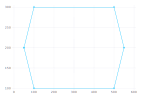

In [29]:
n = 6
cities =    [50 200;
            100 100;
            100 300;
            500 100;
            500 300;
            550 200]
tour = solveTSP(cities)

plot_solution(cities', tour)

#### A more complicated example: TSP in the US
What's the quickest tour around the 48 US state capitals in the mainland US?

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 2400 rows, 2304 columns and 6864 nonzeros
Variable types: 0 continuous, 2304 integer (2304 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 8e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+00]
Presolve removed 2352 rows and 1176 columns
Presolve time: 0.00s
Presolved: 48 rows, 1128 columns, 2256 nonzeros
Variable types: 0 continuous, 1128 integer (1128 binary)
  0.000009 seconds (6 allocations: 2.109 KiB)

Root relaxation: objective 6.333851e+04, 78 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 63338.5149    0   14          - 63338.5149      -     -    0s
  0.000017 seconds (14 allocations: 5.984 KiB)
  0.000030 seconds (29 allocations: 13.250 KiB)
  0.000042 second

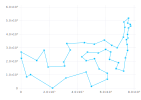

In [31]:
# Source: https://people.sc.fsu.edu/~jburkardt/datasets/tsp/att48.tsp
n=48
citiesdata=[6734 1453;2233 10;5530 1424;401 841;3082 1644;7608 4458;7573 3716;7265 1268;6898 1885;1112 2049;5468 2606;5989 2873;4706 2674;4612 2035;6347 2683;6107 669;7611 5184;7462 3590;7732 4723;5900 3561;4483 3369;6101 1110;5199 2182;1633 2809;4307 2322;675 1006;7555 4819;7541 3981;3177 756;7352 4506;7545 2801;3245 3305;6426 3173;4608 1198;23 2216;7248 3779;7762 4595;7392 2244;3484 2829;6271 2135;4985 140;1916 1569;7280 4899;7509 3239;10 2676;6807 2993;5185 3258;3023 1942]
tour = solveTSP(citiesdata);
plot_solution(citiesdata', tour)

#### A larger-scale TSP: Routing a Vehicle
Let's try to solve a TSP with 200 cities using the above code.

In [32]:
ludata=readdlm("bcl380tsp.txt")
n = 200 #380
ludata = ludata[1:n, 2:3] #drop index
tour_mip = solveTSP(ludata, time_limit=120.)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 40400 rows, 40000 columns and 119800 nonzeros
Variable types: 0 continuous, 40000 integer (40000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+00]
Presolve removed 40200 rows and 20100 columns
Presolve time: 0.05s
Presolved: 200 rows, 19900 columns, 39800 nonzeros
Variable types: 0 continuous, 19900 integer (19900 binary)
  0.000016 seconds (6 allocations: 7.375 KiB)

Root relaxation: objective 1.619982e+03, 281 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1619.98221    0   24          - 1619.98221      -     -    0s
  0.000295 seconds (124 allocations: 215.719 KiB)
  0.000441 seconds (176 allocations: 307.531 KiB

  0.000417 seconds (153 allocations: 266.922 KiB)
  0.000393 seconds (153 allocations: 266.922 KiB)
  0.000372 seconds (144 allocations: 251.031 KiB)
  0.000017 seconds (6 allocations: 7.375 KiB)
  0.000023 seconds (8 allocations: 10.906 KiB)
  0.000376 seconds (148 allocations: 258.094 KiB)
  0.000047 seconds (18 allocations: 28.563 KiB)
  0.000049 seconds (20 allocations: 32.094 KiB)
  0.000036 seconds (14 allocations: 21.500 KiB)
  0.000038 seconds (14 allocations: 21.500 KiB)
  0.000229 seconds (96 allocations: 166.281 KiB)
  0.000061 seconds (25 allocations: 40.922 KiB)
  0.000023 seconds (9 allocations: 12.672 KiB)
  0.000011 seconds (3 allocations: 2.078 KiB)
  0.000045 seconds (17 allocations: 26.797 KiB)
   133   131 1706.94244   26   20          - 1655.57181      -   9.7   46s
  0.000019 seconds (7 allocations: 9.141 KiB)
  0.000316 seconds (127 allocations: 221.016 KiB)
  0.000017 seconds (6 allocations: 7.375 KiB)
  0.000065 seconds (24 allocations: 39.156 KiB)
  0.000020 s

  0.000019 seconds (6 allocations: 7.375 KiB)
  0.000048 seconds (19 allocations: 30.328 KiB)
  0.000080 seconds (31 allocations: 51.516 KiB)
  0.000070 seconds (25 allocations: 40.922 KiB)
  0.000204 seconds (81 allocations: 139.797 KiB)
  0.000231 seconds (80 allocations: 138.031 KiB)
  0.000210 seconds (80 allocations: 138.031 KiB)
  0.000024 seconds (7 allocations: 9.141 KiB)
  0.000029 seconds (8 allocations: 10.906 KiB)
  0.000154 seconds (44 allocations: 74.469 KiB)
  0.000138 seconds (55 allocations: 93.891 KiB)
  0.000139 seconds (53 allocations: 90.359 KiB)
  0.000038 seconds (10 allocations: 14.438 KiB)
   285   285 1723.29885   58   12          - 1655.57181      -   6.4  102s
  0.000242 seconds (61 allocations: 104.484 KiB)
  0.000172 seconds (68 allocations: 116.844 KiB)
  0.000034 seconds (11 allocations: 16.203 KiB)
  0.000103 seconds (41 allocations: 69.172 KiB)
  0.000078 seconds (29 allocations: 47.984 KiB)
   290   289 1756.65692   57   18          - 1655.57181      

MathOptInterface.ResultIndexBoundsError{MathOptInterface.VariablePrimal}: Result index of attribute MathOptInterface.VariablePrimal(1) out of bounds. There are currently 0 solution(s) in the model.

That didn't work very well!

**What went wrong?**

a) TSP is NP-hard, so we can't solve it and we should just give up.

b) **We have been focusing on lower bounds, but we also need good heuristics to get good upper bounds.**


Answer: **(b) [notice that we didn't even find a feasible solution!]**


We will use the package TravelingSalesmanHeuristics.jl to generate a high-quality warm-start.

Heuristic method solution cost: 879.7592926128336


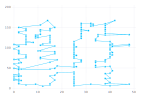

In [33]:
# pkg> add "https://github.com/evanfields/TravelingSalesmanHeuristics.jl/"
using TravelingSalesmanHeuristics

# Calculate pairwise distance matrix for a heuristic
dist = [norm(ludata[i,:] - ludata[j,:]) for i in 1:n, j in 1:n];
# Call heuristic solution method
Random.seed!(47)
tour_heuristic, cost=solve_tsp(dist, quality_factor = 100)
cost = sum(dist[tour_heuristic[i],tour_heuristic[i+1]] for i=1:n) + dist[tour_heuristic[n+1],tour_heuristic[1]]
println("Heuristic method solution cost: $cost")
plot_solution(ludata', tour_heuristic)

The above solution is pretty good, but it turns out that we can obtain a better one after injecting the above solution as a warm-start and rerunning our MIO solver.

Let's define a new version of solveTSP which takes a warm start solution, and tunes our solver more cleverly.

In [34]:
function solveTSP(cities, warmstart; time_limit = 30.0)

    # Calculate pairwise distance matrix
    n = size(cities)[1]
    dist = [norm(cities[i,:] - cities[j,:]) for i in 1:n, j in 1:n]

    m = Model(Gurobi.Optimizer)
    set_time_limit_sec(m, time_limit)

    ################################
    # NOTE: Provide warm start here!
    ################################
    # x[i,j] is 1 iff we travel between i and j, 0 otherwise. 
    # Although we define all n^2 variables, we will only use the (strict) upper triangle. 
    @variable(m, x[i=1:n,j=1:n], Bin, start=warmstart[i,j])

    # Minimize total length of tour
    @objective(m, Min, dot(dist, x))

    # Make x_ij and x_ji be the same thing (undirectional TSP)
    @constraint(m, x.==x')
    # Don't allow self-arcs, by ensuring diagonal is vector of 0s
    @constraint(m, diag(x).==zeros(n))

    # We must enter and leave every city once and only once
    for i = 1:n
        @constraint(m, sum(x[i,j] for j=1:n) == 2)
    end

    # Lazy constraint
    lazy_called = false  
    function subtour(cb)
        lazy_called = true
        # Find any set of cities in a subtour
        x_val = callback_value.(Ref(cb), x)
        @time subtour, subtour_length = findSubtour(n, x_val)

        if subtour_length == n
            # This "subtour" is actually all cities, so we are done with this node of the branch and bound tree
            return
        end

        # Subtour found - add lazy constraint
        arcs_from_subtour = zero(AffExpr)
        for i = 1:n
            if subtour[i]
            # If this city isn't in subtour, skip it
                for j = 1:n
                    # Want to include all arcs from this city, which is in the subtour, 
                    # to all cities not in the subtour
                    if (i !=j) && !(subtour[j])
                        # j isn't in subtour
                        arcs_from_subtour += x[i,j]
                    end
                end
            end
        end
        # Add the subtour elimination constraint
        con = @build_constraint(arcs_from_subtour >= 2)
        MOI.submit(m, MOI.LazyConstraint(cb), con)
    end 

    MOI.set(m, MOI.LazyConstraintCallback(), subtour)
    
    optimize!(m)

    return extractTour(n, value.(x))
end

solveTSP (generic function with 2 methods)

Let's test our new solver!
Notice that the solution reached is provably optimal (up to solver tolerances)!
This also verifies that the heuristic solution obtained earlier is indeed of high-quality.

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 40400 rows, 40000 columns and 119800 nonzeros
Variable types: 0 continuous, 40000 integer (40000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+00]

  0.000453 seconds (202 allocations: 353.438 KiB)
Loaded MIP start with objective 1759.52

Presolve removed 40200 rows and 20100 columns
Presolve time: 0.05s
Presolved: 200 rows, 19900 columns, 39800 nonzeros
Variable types: 0 continuous, 19900 integer (19900 binary)

Root relaxation: objective 1.619982e+03, 277 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1619.98221    0   24 1759.51859 1619.98221  7.93%     -    0s
  0.000281 seconds (97 allocations: 168.047 KiB)
  0

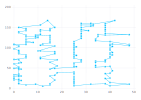

In [36]:
warmstart=zeros(n,n);
for i=1:n
    warmstart[tour_heuristic[i], tour_heuristic[i+1]]=1.0;
    warmstart[tour_heuristic[i+1], tour_heuristic[i]]=1.0;
end
warmstart[tour_heuristic[n], tour_heuristic[1]]=1.0;
warmstart[tour_heuristic[1], tour_heuristic[n]]=1.0;

tour_mip_warm = solveTSP(ludata, warmstart, time_limit=120.0)
cost = sum(dist[tour_mip_warm[i],tour_mip_warm[i+1]] for i=1:n) + dist[tour_mip_warm[n+1],tour_mip_warm[1]]
println("MIP with warm start solution cost: $cost")
plot_solution(ludata', tour_mip_warm)

#### The Concorde App
* The code laid out above doesn't scale to n=1000s, because of the way we laid out the problem data, and because we aren't using every trick in the book: e.g., we made Julia compute the full distance matrix, which is expensive.

* The heuristic we are using is also not quite state-of-the-art: it uses 2-opt swaps, but we get better solutions with 2-opt and 3-opt swaps.

* These issues are dealt with in the Concorde TSP code, a state-of-the-art TSP solver which solves TSPs with millions of variables to certifiable optimality by carefully managing its memory and using lots of other "tricks" from the literature. 

**If you have an iPhone, download the (free) Concorde app and try it out!**

**See here: http://www.math.uwaterloo.ca/tsp/iphone/index.html, or the app store.**



# Credit + References

This material is adapted from previous versions of this course, which have been designed by numerous ORC students.

Some of the sources used to create this year's version include:
 - JuMP documentation
 - Gurobi documentation
 - https://orinanobworld.blogspot.com/2012/08/user-cuts-versus-lazy-constraints.html